# [Paris Saclay Center for Data Science](http://www.datascience-paris-saclay.fr)

## [Fake news RAMP](http://www.ramp.studio/problems/fake_news): classify statements of public figures

_Emanuela Boros (LIMSI/CNRS), Balázs Kégl (LAL/CNRS), Roman Yurchak (Symerio)_

## Introduction
This is an initiation project to introduce RAMP and get you to know how it works.

The goal is to develop prediction models able to **identify which news is fake**. 

The data we will manipulate is from http://www.politifact.com. The input contains of short statements of public figures (and sometimes anonymous bloggers), plus some metadata. The output is a truth level, judged by journalists at Politifact. They use six truth levels which we coded into integers to obtain an [ordinal regression](https://en.wikipedia.org/wiki/Ordinal_regression) problem:
```
0: 'Pants on Fire!'
1: 'False'
2: 'Mostly False'
3: 'Half-True'
4: 'Mostly True'
5: 'True'
```
You goal is to classify each statement (+ metadata) into one of the categories.

### Requirements

* numpy>=1.10.0  
* matplotlib>=1.5.0 
* pandas>=0.19.0  
* scikit-learn>=0.17 (different syntaxes for v0.17 and v0.18)   
* seaborn>=0.7.1
* nltk

Further, an nltk dataset needs to be downloaded:

```
python -m nltk.downloader popular
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Exploratory data analysis

### Loading the data

In [2]:
train_filename = 'data/train.csv'
data = pd.read_csv(train_filename, sep='\t')
data = data.fillna('')
data['date'] = pd.to_datetime(data['date'])
data

,date,edited_by,job,researched_by,source,state,statement,subjects,truth
0,2013-08-29,Angie Drobnic Holan,Republican,Jon Greenberg,Scott Walker,Wisconsin,"In the Wisconsin health insurance exchange, ""t...",['Health Care'],3
1,2013-08-29,Angie Drobnic Holan,Republican,Louis Jacobson,Mike Huckabee,Arkansas,"""America’s gun-related homicide rate … would b...","['Crime', 'Guns', 'Pundits']",0
2,2013-08-29,Greg Borowski,,Tom Kertscher,League of Conservation Voters,,Says U.S. Sen. Ron Johnson voted to let oil an...,"['Climate Change', 'Energy', 'Environment', 'T...",5
3,2013-08-28,Aaron Sharockman,,Rochelle Koff,National Republican Congressional Committee,,"""Congressman Patrick Murphy voted to keep the ...",['Health Care'],2
4,2013-08-28,Aaron Sharockman,,Angie Drobnic Holan,Janet Napolitano,,"The 2010 DREAM Act failed despite ""strong bipa...","['Bipartisanship', 'Immigration']",2
5,2013-08-28,W. Gardner Selby,Republican,Sue Owen,Steve Stockman,Texas,"Says U.N. arms treaty will mandate a ""new inte...",['Guns'],1
6,2013-08-28,Greg Borowski,Democrat,Dave Umhoefer,Mark Harris,Wisconsin,"""I’ve got the spending down, I’ve got the debt...","['County Budget', 'County Government', 'Debt',...",4
7,2013-08-28,"Jim Denery, Jim Tharpe",Democrat,Eric Stirgus,Doug Stoner,Georgia,"""I fought hard for that (state Senate) seat. I...","['Campaign Finance', 'Candidate Biography']",2
8,2013-08-27,Angie Drobnic Holan,None,Louis Jacobson,Moms Demand Action for Gun Sense In America,Indiana,"The book Little Red Riding Hood is something ""...","['Education', 'Guns']",2
9,2013-08-27,Angie Drobnic Holan,,Julie Kliegman,BookerFail,,"""Three years after getting the $100 million (f...",['Education'],2


In [3]:
data.dtypes

date             datetime64[ns]
edited_by                object
job                      object
researched_by            object
source                   object
state                    object
statement                object
subjects                 object
truth                     int64
dtype: object

In [4]:
data.describe()

,truth
count,7569.000000
mean,2.740917
std,1.588681
min,0.000000
25%,1.000000
50%,3.000000
75%,4.000000
max,5.000000


In [5]:
data.count()

date             7569
edited_by        7569
job              7569
researched_by    7569
source           7569
state            7569
statement        7569
subjects         7569
truth            7569
dtype: int64

The original training data frame has 13000+ instances. In the starting kit, we give you a subset of 7569 instances for training and 2891 instances for testing.

Most columns are categorical, some have high cardinalities.

['' 'Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida' 'Georgia'
 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota'
 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'New Hampshire'
 'New Jersey' 'New Mexico' 'New York' 'North Carolina' 'North Dakota'
 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Rhode Island' 'Rhode island'
 'South Carolina' 'South Dakota' 'Tennesse' 'Tennessee' 'Texas'
 'United Kingdom' 'Utah' 'Vermont' 'Virgina' 'Virginia' 'Washington'
 'Washington state' 'Washington, D.C.' 'West Virginia' 'Wisconsin'
 'Wyoming' 'ohio' 'the United States']
60


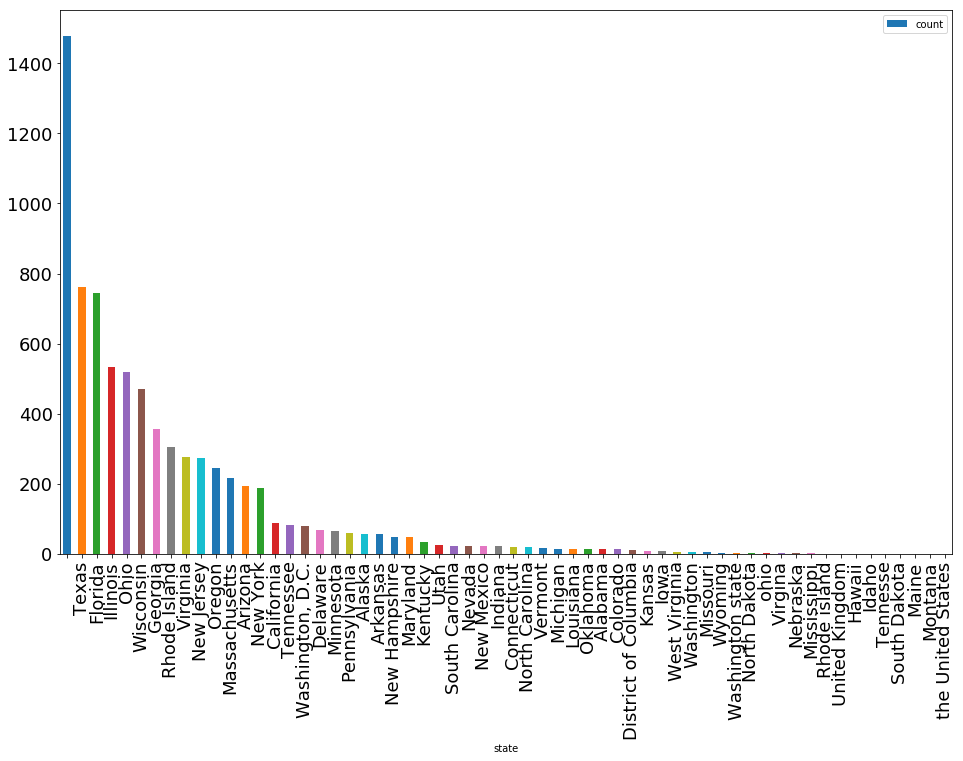

In [6]:
print(np.unique(data['state']))
print(len(np.unique(data['state'])))
data.groupby('state').count()[['job']].sort_values(
    'job', ascending=False).reset_index().rename(
    columns={'job': 'count'}).plot.bar(
    x='state', y='count', figsize=(16, 10), fontsize=18)

['' 'Activist' 'Business leader' 'Columnist' 'Constitution Party'
 'Democrat' 'Democratic Farmer-Labor' 'Independent' 'Journalist'
 'Labor leader' 'Libertarian' 'Newsmaker' 'None'
 'Ocean State Tea Party in Action' 'Organization' 'Republican'
 'State official' 'Talk show host' 'Tea Party member' 'county commissioner']
20


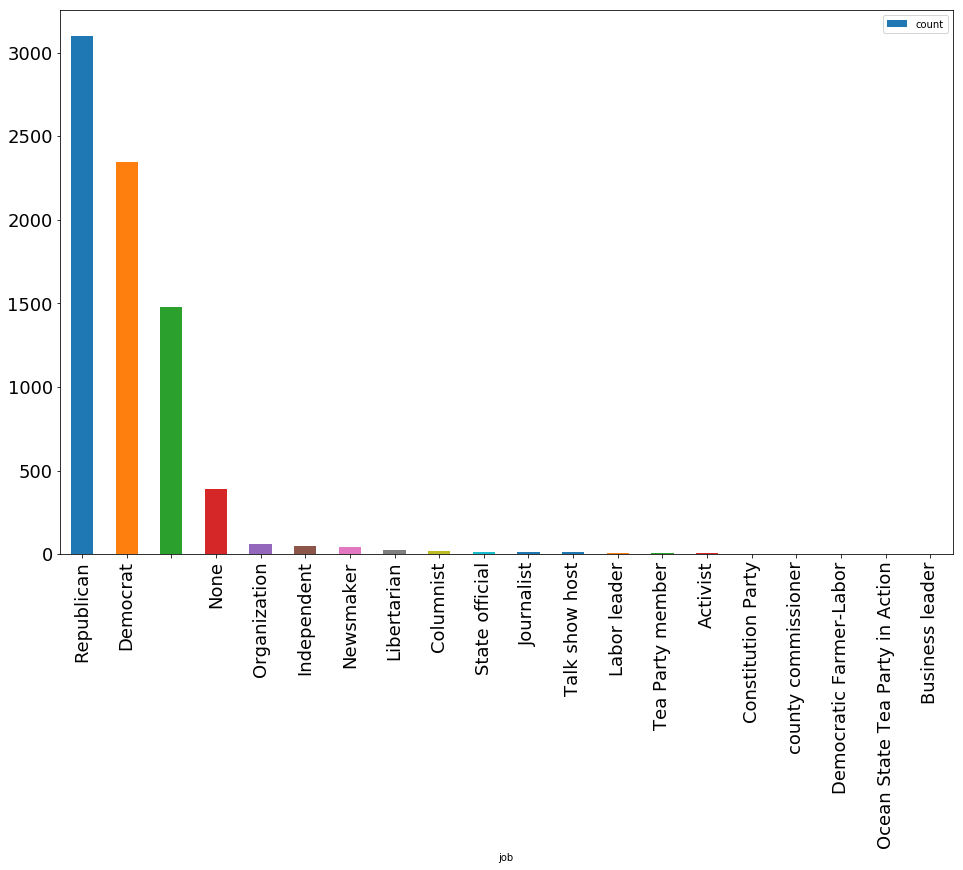

In [7]:
print(np.unique(data['job']))
print(len(np.unique(data['job'])))
data.groupby('job').count()[['state']].rename(
    columns={'state': 'count'}).sort_values(
    'count', ascending=False).reset_index().plot.bar(
        x='job', y='count', figsize=(16, 10), fontsize=18);

If you want to use the journalist and the editor as input, you will need to split the lists since sometimes there are more than one of them on an instance.

['' 'Aaron Sharockman' 'Adriel Bettelheim, Amy Hollyfield' 'Alexander Lane'
 'Amy Hollyfield' 'Amy Hollyfield, Aaron Sharockman'
 'Amy Hollyfield, Greg Joyce' 'Amy Hollyfield, Scott Montgomery'
 'Amy Sherman' 'Angie Drobnic Holan'
 'Angie Drobnic Holan, Aaron Sharockman'
 'Angie Drobnic Holan, Elizabeth Miniet, Jim Tharpe' 'Bill Adair'
 'Bill Adair, Aaron Sharockman' 'Bill Adair, Amy Hollyfield'
 'Bill Adair, Angie Drobnic Holan' 'Bill Adair, Martha M. Hamilton'
 'Bill Adair, Scott Montgomery' 'Bill Adair, Sergio Bustos'
 'Bill Adair, Steve Ahillen, Zack McMillin' 'Bill Adair, Tom Chester'
 'Bill Adair, Tom Chester, Michael Erskine' 'Bill Adair, W. Gardner Selby'
 'Bill Adair, Zack McMillin' 'Bill Duryea' 'Bob Gee' 'Brenda Bell'
 'Brenda Bell, Jody Seaborn' 'Brenda Bell, W. Gardner Selby'
 'Bridget Hall Grumet' 'Bridget Hall Grumet, Angie Drobnic Holan'
 'Bruce  Hammond' 'C. Eugene Emery Jr.' 'Caryn Shinske' 'Catharine Richert'
 'Charles Gay' 'Charles Gay, Elizabeth Miniet' 'Chris Quin

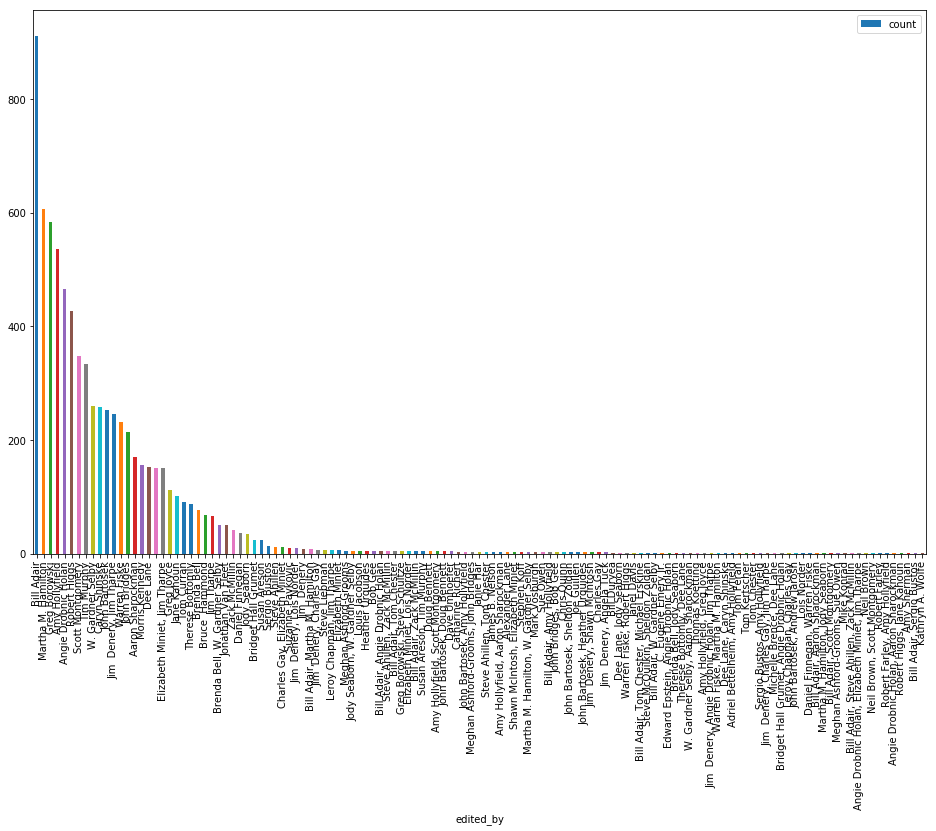

In [8]:
print(np.unique(data['edited_by']))
print(len(np.unique(data['edited_by'])))
data.groupby('edited_by').count()[['state']].rename(
    columns={'state': 'count'}).sort_values(
    'count', ascending=False).reset_index().plot.bar(
        x='edited_by', y='count', figsize=(16, 10), fontsize=10);

In [9]:
print(np.unique(data['researched_by']))
print(len(np.unique(data['researched_by'])))

['' 'Aaron Marshall' 'Aaron Sharockman' 'Aaron Sharockman, Amy Sherman'
 'Adriel Bettelheim' 'Adriel Bettelheim, Angie Drobnic Holan'
 'Adriel Bettelheim, David DeCamp' 'Adriel Bettelheim, Ryan Kelly'
 'Alaina Berner, Christopher Connors, Louis Jacobson' 'Alex Holt'
 'Alex Holt, Louis Jacobson' 'Alex Holt, Michelle Sutherland'
 'Alex Kuffner' 'Alex Leary' 'Alexander Lane' 'Amy Hollyfield'
 'Amy Sherman' 'Amy Sherman, Bartholomew Sullivan' 'Andra Lim'
 'Angie Drobnic Holan' 'Angie Drobnic Holan, Aaron Sharockman'
 'Angie Drobnic Holan, Alex Leary' 'Angie Drobnic Holan, Alexander Lane'
 'Angie Drobnic Holan, Amy Sherman'
 'Angie Drobnic Holan, Amy Sherman, Dave Umhoefer'
 'Angie Drobnic Holan, Catharine Richert'
 'Angie Drobnic Holan, Craig Pittman'
 'Angie Drobnic Holan, David G. Taylor'
 'Angie Drobnic Holan, Ian K. Kullgren'
 'Angie Drobnic Holan, Jeffrey S.  Solochek'
 'Angie Drobnic Holan, John Martin' 'Angie Drobnic Holan, Katie Sanders'
 'Angie Drobnic Holan, Louis Jacobson'
 'Ang

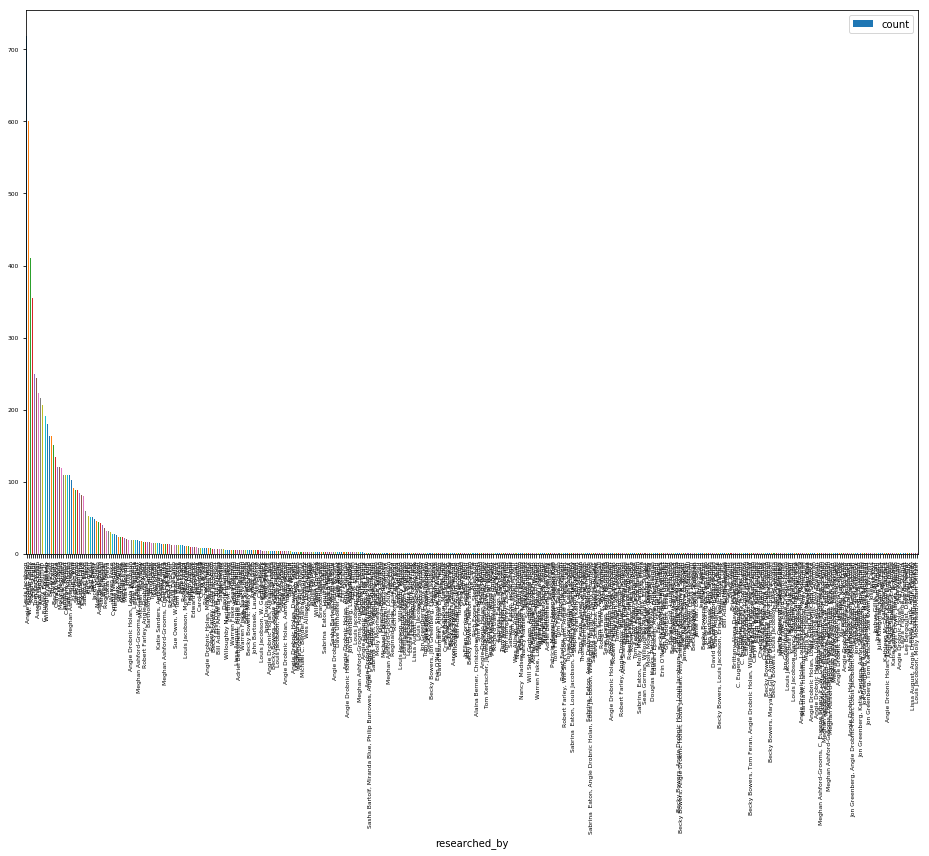

In [10]:
data.groupby('researched_by').count()[['state']].sort_values(
    'state', ascending=False).reset_index().rename(
    columns={'state': 'count'}).plot.bar(
        x='researched_by', y='count', figsize=(16, 10), fontsize=6);

There are 2000+ different sources.

['13th District GOP slate' '18% of the American public'
 '60 Plus Association' ..., 'Zell Miller' 'Zoe Lofgren' 'billhislam.com']
2124


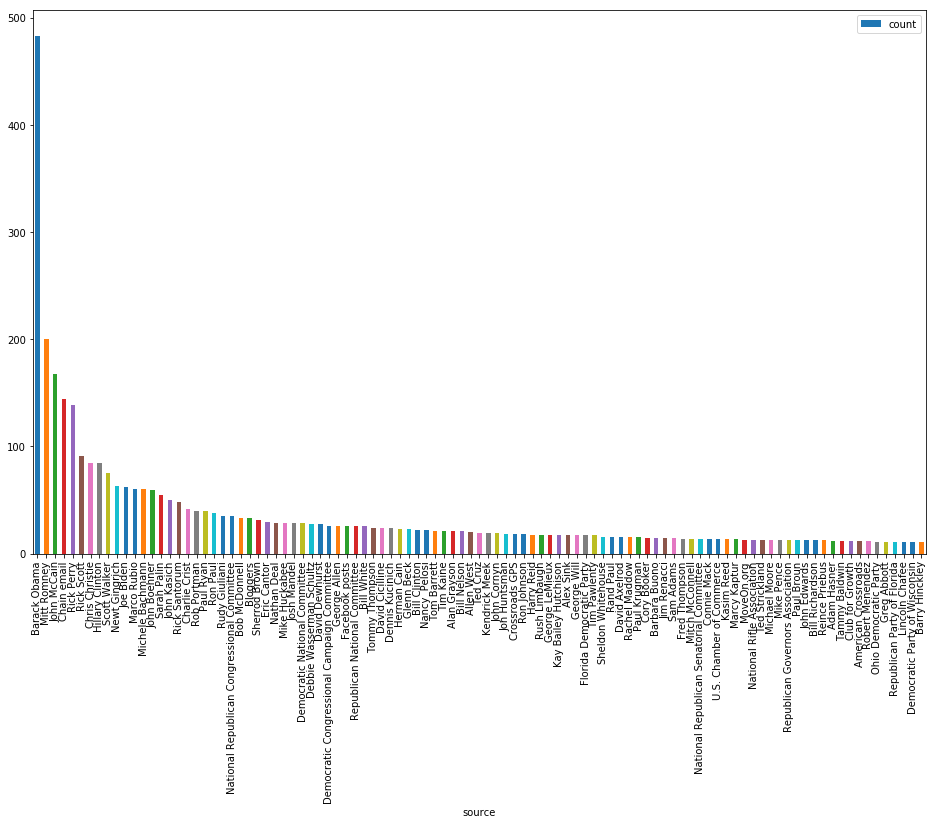

In [11]:
print(np.unique(data['source']))
print(len(np.unique(data['source'])))
data.groupby('source').count()[['state']].rename(
    columns={'state': 'count'}).sort_values(
    'count', ascending=False).reset_index().loc[:100].plot.bar(
        x='source', y='count', figsize=(16, 10), fontsize=10);

### Predicting truth level

The goal is to predict the truthfulness of statements. Let us group the data according to the `truth` columns:

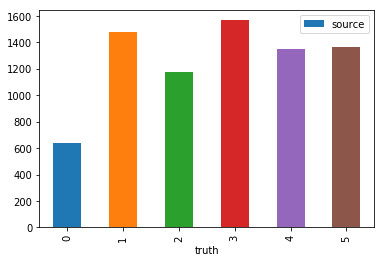

In [12]:
data.groupby('truth').count()[['source']].reset_index().plot.bar(x='truth', y='source');

## The pipeline

For submitting at the [RAMP site](http://ramp.studio), you will have to write two classes, saved in two different files:   
* the class `FeatureExtractor`, which will be used to extract features for classification from the dataset and produce a numpy array of size (number of samples $\times$ number of features). 
* a class `Classifier` to predict 

### Feature extraction

The feature extractor implements a `transform` function. It is saved in the file [`submissions/starting_kit/feature_extractor.py`](/edit/submissions/starting_kit/feature_extractor.py). It receives the pandas dataframe `X_df` defined at the beginning of the notebook. It should produce a numpy array representing the extracted features, which will then be used for the classification.  

**Note:** the following code cells are *not* executed in the notebook. The notebook saves their contents in the file specified in the first line of the cell, so you can edit your submission before running the local test below and submitting it at the RAMP site.

In [171]:
%%file submissions/starting_kit/feature_extractor.py
# -*- coding: utf-8 -*-

from __future__ import unicode_literals
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

# BEGIN
import unicodedata
import pandas as pd
import numpy as np

def document_preprocessor(doc):
    try:
        doc = unicode(doc, 'utf-8')
        print doc
    except (TypeError, UnicodeDecodeError, NameError):  # unicode is a default on python 3
        pass
    doc = unicodedata.normalize('NFD', doc)
    doc = doc.encode('ascii', 'ignore')
    doc = doc.decode("utf-8")
    return str(doc)


stemmer = SnowballStemmer('english')

def token_processor(tokens):
    for token in tokens:
        yield stemmer.stem(token)
# END

class FeatureExtractor(TfidfVectorizer):
    """Convert a collection of raw docs to a matrix of TF-IDF features. """

    def __init__(self):
        # print 1
        # see ``TfidfVectorizer`` documentation for other feature
        # extraction parameters.
        super(FeatureExtractor, self).__init__(analyzer = 'word', preprocessor=document_preprocessor)

    def fit(self, X_df, y=None):
        # print 2    
        super(FeatureExtractor, self).fit(X_df['statement'])
        return self

    def fit_transform(self, X_df, y=None):
        # print 3
        return self.fit(X_df).transform(X_df)

    def transform(self, X_df):
        # print 4             
                    
        X_df = X_df.fillna('')                
        X_cols = X_df.select_dtypes(include = [np.object]).columns
        X_df[X_cols] = X_df[X_cols].apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8'))
        
        X = pd.DataFrame()
        X['#index_'] = X_df.index
        X['#date_'] = pd.to_datetime(X_df['date']).apply(lambda x: int(x.value) if x else -1)      
        X['#edited_by_'] = X_df['edited_by']
        X['#job_'] = X_df['edited_by']
        X['#researched_by_'] = X_df['researched_by']
        X['#source_'] = X_df['source']
        X['#state_'] = X_df['state']
        X['#subjects_'] = X_df['subjects']
        
        vectorizer = super(FeatureExtractor, self)        
        tfidf = vectorizer.transform(X_df['statement'])
        feature_names = vectorizer.get_feature_names()     
        tfidf_df = pd.DataFrame(tfidf.A, columns = feature_names)  
        for value in tfidf_df.columns:
            X['#statement_' + value] = tfidf_df[value]
         
        X = X.fillna(0)
        
        return X

    def build_tokenizer(self):
        # print 5
        tokenize = super(FeatureExtractor, self).build_tokenizer()
        return lambda doc: list(token_processor(tokenize(doc)))

Overwriting submissions/starting_kit/feature_extractor.py


## Classifier

The classifier follows a classical scikit-learn classifier template. It should be saved in the file [`submissions/starting_kit/classifier.py`](/edit/submissions/starting_kit/classifier.py). In its simplest form it takes a scikit-learn pipeline, assigns it to `self.clf` in `__init__`, then calls its `fit` and `predict_proba` functions in the corresponding member functions.

In [221]:
%%file submissions/starting_kit/classifier.py
# -*- coding: utf-8 -*-
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM

# BEGIN
from itertools import groupby
import pandas as pd
import numpy as np
import re

def column_processor(data, column):
    brackets = re.compile('\[(.*?)\]')
    drop = []
    for index, row in data.iterrows():
        values = str(row[column])
        if brackets.match(values):
            data.set_value(index, column, row[column][1:-1])
        values = values.split(',')
        if len(values) > 1:    
            for value in values:
                row[column] = value.strip()
                data = data.append(row, ignore_index = True)  
            drop.append(index)
    return data.drop(drop) 

def value_processor(data):
    return np.unique(data.str.lower());

def cell_processor(data, values):    
    return data.apply(lambda x: values.tolist().index(x.lower()) if str(x).lower() in values else -1)

def extract_columns(data, prefix):  
    columns = []
    for column in data.columns:
        if prefix in column:
            columns.append(column)
    return columns

def extract_frame(data, prefix):  
    X = pd.DataFrame()
    for column in data.columns:
        if prefix in column:
            X[column] = data[column]
    return X

def shape_frame(data, columns):
    X = pd.DataFrame()
    for column in columns:
        if column in data.columns:
            X[column] = data[column]
        else:
            X[column] = 0
    return X

def shape_results(y, index):        
    results = np.zeros((len(np.unique(index)), y.shape[1]))
    for row in index.values:
        results[row] = np.sum([results[row], y[row]], axis = 0)        
    return results / results.sum(axis = 1, keepdims = True)
# END

class Classifier(BaseEstimator):
    def __init__(self):
        # print 6
        self.text_pa_clf = PassiveAggressiveClassifier()
        
        self.text_lstm_clf = Sequential()
        self.text_lstm_clf.add(Embedding(100000, 128))
        self.text_lstm_clf.add(LSTM(128, dropout = 0.2, recurrent_dropout = 0.2))
        self.text_lstm_clf.add(Dense(1, activation = 'sigmoid'))
        self.text_lstm_clf.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
        
        self.class_clf = AdaBoostClassifier()
        
        self.edited_by = None
        self.job = None
        self.researched_by = None
        self.source = None
        self.state = None
        self.subjects = None

    def fit(self, X, y):        
        # print 7
        X['#y_'] = y

        X = column_processor(X, '#edited_by_')
        X = column_processor(X, '#job_')
        X = column_processor(X, '#researched_by_')
        X = column_processor(X, '#source_')
        X = column_processor(X, '#state_')
        X = column_processor(X, '#subjects_')

        X_data = pd.DataFrame()
        #X_data = pd.concat([X_data, extract_frame(X, '#date_')], axis = 1)
        X_data = pd.concat([X_data, extract_frame(X, '#edited_by_')], axis = 1)
        X_data = pd.concat([X_data, extract_frame(X, '#job_')], axis = 1)
        X_data = pd.concat([X_data, extract_frame(X, '#researched_by_')], axis = 1)
        X_data = pd.concat([X_data, extract_frame(X, '#source_')], axis = 1)
        #X_data = pd.concat([X_data, extract_frame(X, '#state_')], axis = 1)
        X_data = pd.concat([X_data, extract_frame(X, '#subjects_')], axis = 1)
        X_data = pd.concat([X_data, extract_frame(X, '#statement_')], axis = 1)

        tfidf = extract_frame(X, '#statement_')
        
        self.edited_by = value_processor(X_data['#edited_by_'])
        self.job = value_processor(X_data['#job_'])
        self.researched_by = value_processor(X_data['#researched_by_'])
        self.source = value_processor(X_data['#source_'])
        #self.state = value_processor(X_data['#state_'])
        self.subjects = value_processor(X_data['#subjects_'])
        #self.text_lstm_clf.model.fit(tfidf, X['#y_'].values, batch_size = 32, epochs = 10)

        #X_data['#y_'] = self.text_lstm_clf.predict_on_batch(tfidf.values)        
        X_data['#edited_by_'] = cell_processor(X_data['#edited_by_'], self.edited_by)
        X_data['#job_'] = cell_processor(X_data['#job_'], self.edited_by)
        X_data['#researched_by_'] = cell_processor(X_data['#researched_by_'], self.edited_by)
        X_data['#source_'] = cell_processor(X_data['#source_'], self.edited_by)
        #X_data['#state_'] = cell_processor(X_data['#state_'], self.edited_by)
        X_data['#subjects_'] = cell_processor(X_data['#subjects_'], self.edited_by)

        #self.class_clf.fit(X_data.values, X['#y_'].values)
        self.text_lstm_clf.model.fit(tfidf.values, X['#y_'].values, batch_size = 32, epochs = 1)

        print self.text_lstm_clf.outputs
        
    def predict(self, X):
        # print 8
        X = column_processor(X, '#edited_by_')
        
        X_data = pd.DataFrame()        
        #X_data = pd.concat([X_data, extract_frame(X, '#date_')], axis = 1)
        X_data = pd.concat([X_data, extract_frame(X, '#edited_by_')], axis = 1)
        X_data = pd.concat([X_data, extract_frame(X, '#job_')], axis = 1)
        X_data = pd.concat([X_data, extract_frame(X, '#researched_by_')], axis = 1)
        X_data = pd.concat([X_data, extract_frame(X, '#source_')], axis = 1)
        #X_data = pd.concat([X_data, extract_frame(X, '#state_')], axis = 1)
        X_data = pd.concat([X_data, extract_frame(X, '#subjects_')], axis = 1)
        X_data = pd.concat([X_data, extract_frame(X, '#statement_')], axis = 1)
        
        tfidf = extract_frame(X, '#statement_')
        
        #X_data['#y_'] = self.text_lstm_clf.predict_on_batch(tfidf.values)        
        X_data['#edited_by_'] = cell_processor(X_data['#edited_by_'], self.edited_by)
        X_data['#job_'] = cell_processor(X_data['#job_'], self.edited_by)
        X_data['#researched_by_'] = cell_processor(X_data['#researched_by_'], self.edited_by)
        X_data['#source_'] = cell_processor(X_data['#source_'], self.edited_by)
        #X_data['#state_'] = cell_processor(X_data['#state_'], self.edited_by)
        X_data['#subjects_'] = cell_processor(X_data['#subjects_'], self.edited_by)
        
        #return self.class_clf.predict(X_data.values)
        #return self.text_lstm_clf.predict(X_data.values)

    def predict_proba(self, X):
        # print 9
        X = column_processor(X, '#edited_by_')
        
        X_data = pd.DataFrame()        
        #X_data = pd.concat([X_data, extract_frame(X, '#date_')], axis = 1)
        X_data = pd.concat([X_data, extract_frame(X, '#edited_by_')], axis = 1)
        X_data = pd.concat([X_data, extract_frame(X, '#job_')], axis = 1)
        X_data = pd.concat([X_data, extract_frame(X, '#researched_by_')], axis = 1)
        X_data = pd.concat([X_data, extract_frame(X, '#source_')], axis = 1)
        #X_data = pd.concat([X_data, extract_frame(X, '#state_')], axis = 1)
        X_data = pd.concat([X_data, extract_frame(X, '#subjects_')], axis = 1)
        X_data = pd.concat([X_data, extract_frame(X, '#statement_')], axis = 1)
        
        tfidf = extract_frame(X, '#statement_')
        
        #X_data['#y_'] = self.text_lstm_clf.predict_on_batch(tfidf.values)                
        X_data['#edited_by_'] = cell_processor(X_data['#edited_by_'], self.edited_by)
        X_data['#job_'] = cell_processor(X_data['#job_'], self.edited_by)
        X_data['#researched_by_'] = cell_processor(X_data['#researched_by_'], self.edited_by)
        X_data['#source_'] = cell_processor(X_data['#source_'], self.edited_by)
        #X_data['#state_'] = cell_processor(X_data['#state_'], self.edited_by)
        X_data['#subjects_'] = cell_processor(X_data['#subjects_'], self.edited_by)
    
        return shape_results(self.text_lstm_clf.predict_proba(tfidf.values), X['#index_'])

Overwriting submissions/starting_kit/classifier.py


## Testing data

In [222]:
#pd.merge(data[['edited_by']], data[['researched_by']], how='inner', left_on='edited_by', right_on='researched_by')

## Local testing (before submission)

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. For this we provide a unit test. Note that the test runs on your files in [`submissions/starting_kit`](/tree/submissions/starting_kit), not on the classes defined in the cells of this notebook.

First `pip install ramp-workflow` or install it from the [github repo](https://github.com/paris-saclay-cds/ramp-workflow). Make sure that the python files `feature_extractor.py` and `classifier.py` are in the  [`submissions/starting_kit`](/tree/submissions/starting_kit) folder, and the data `train.csv` and `test.csv` are in [`data`](/tree/data). Then run

```ramp_test_submission```

If it runs and print training and test errors on each fold, then you can submit the code.

In [ ]:
!ramp_test_submission --quick-test

Testing Fake news: classify statements of public figures
Reading train and test files from ./data ...
Reading cv ...
Training ./submissions/starting_kit ...
CV fold 0
./submissions/starting_kit/feature_extractor.py:3: RuntimeWarning: Parent module '.submissions.starting_kit' not found while handling absolute import
  from __future__ import unicode_literals
./submissions/starting_kit/feature_extractor.py:4: RuntimeWarning: Parent module '.submissions.starting_kit' not found while handling absolute import
  from nltk.stem import SnowballStemmer
./submissions/starting_kit/feature_extractor.py:5: RuntimeWarning: Parent module '.submissions.starting_kit' not found while handling absolute import
  from sklearn.feature_extraction.text import TfidfVectorizer
./submissions/starting_kit/feature_extractor.py:8: RuntimeWarning: Parent module '.submissions.starting_kit' not found while handling absolute import
  import unicodedata
./submissions/starting_kit/feature_extractor.py:9: RuntimeWarning: P